In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
### MOVIE DATABASES ###

# Box Office Mojo by IMDb Pro
movie_gross_df = pd.read_csv('../data/zippedData/bom.movie_gross.csv.gz')

# IMDb
imdb_name_df = pd.read_csv('../data/zippedData/imdb.name.basics.csv.gz')
imdb_akas_df = pd.read_csv('../data/zippedData/imdb.title.akas.csv.gz')
imdb_basics_df = pd.read_csv('../data/zippedData/imdb.title.basics.csv.gz')
imdb_crew_df = pd.read_csv('../data/zippedData/imdb.title.crew.csv.gz')
imdb_principals_df = pd.read_csv('../data/zippedData/imdb.title.principals.csv.gz')
imdb_ratings_df = pd.read_csv('../data/zippedData/imdb.title.ratings.csv.gz')

# Rotten Tomatos
rt_movies_df = pd.read_csv('../data/zippedData/rt.movie_info.tsv.gz', sep='\t')
rt_reviews_df = pd.read_csv('../data/zippedData/rt.reviews.tsv.gz', sep='\t', encoding= 'unicode_escape')

# The Movie Database
tmdb_movies_df = pd.read_csv('../data/zippedData/tmdb.movies.csv.gz')

# The Numbers
tn_budgets_df = pd.read_csv('../data/zippedData/tn.movie_budgets.csv.gz')

Cleaning data from the given csv files

In [5]:
imdb_basics = imdb_basics_df
imdb_basics = imdb_basics.rename(columns = {'primary_title' : 'title'})

Creating a Profit Column for each movie.

In [6]:
tn_budgets = tn_budgets_df
tn_budgets = tn_budgets.rename(columns = {'movie' : 'title'})
tn_budgets['worldwide_gross'] = tn_budgets['worldwide_gross'].str.replace("$","").str.replace(",","").astype(float)
tn_budgets['production_budget'] = tn_budgets['production_budget'].str.replace("$","").str.replace(",","").astype(float)
tn_budgets['profit'] = tn_budgets['worldwide_gross'] - tn_budgets['production_budget']

In [7]:
movie_gross_and_basics = imdb_basics.merge(tn_budgets, how = 'inner', on ='title')
movie_gross_and_basics = movie_gross_and_basics.drop_duplicates(subset = ['title'])

In [8]:
imdb_name = imdb_name_df
imdb_crew = imdb_crew_df
imdb_crew = imdb_crew.merge(movie_gross_and_basics[['title', 'tconst']], on = 'tconst', how = 'left', validate = 'one_to_many')
imdb_crew = imdb_crew.dropna(subset = ['title'])

In [9]:
imdb_ratings = imdb_ratings_df
imdb_ratings = imdb_ratings.merge(movie_gross_and_basics, on = 'tconst', how = 'left', validate = 'one_to_many')
imdb_ratings = imdb_ratings.dropna(subset = ['title']).sort_values('averagerating', ascending = False).drop(columns = ['original_title'], axis = 1)
imdb_ratings['release_date'] = pd.to_datetime(imdb_ratings['release_date'])

Matching writers names to the movies they wrote. Creating a column with Return on Investment for the given writers.

In [10]:
writers = imdb_crew.assign(writers = lambda x :imdb_crew['writers'].str.split(','))
writers_profit = writers.explode('writers').merge(imdb_ratings, on = 'tconst', how = 'left', validate = 'many_to_one')
writers_profit['ROI'] = writers_profit['profit']/writers_profit['production_budget']*100
writers_profit = writers_profit.dropna(subset = ['ROI'])

In [11]:
writers_profit = writers_profit.merge(imdb_name[['primary_name', 'nconst']], left_on = ['writers'], right_on = 'nconst', how = 'left', validate = 'many_to_one')
writers_profit = writers_profit.merge(imdb_basics[['tconst', 'title']], on = 'tconst', how = 'left', validate = 'many_to_one')

Finding the top writers in Hollywood based on Return on Investment, filtering for those that have released work since the year 2000. 

In [12]:
top_writers = writers_profit.where(writers_profit['ROI'] > 1).sort_values('ROI', ascending = False)
top_writers_2000 = top_writers[(top_writers['release_date'] > '2000-1-1')]
top_writers_2000.corrwith(top_writers_2000['ROI'])

averagerating       -0.025347
numvotes             0.015461
start_year           0.008771
runtime_minutes     -0.049858
id                   0.031063
production_budget   -0.095270
worldwide_gross      0.027985
profit               0.059811
ROI                  1.000000
dtype: float64

In [13]:
writers_plot = top_writers_2000.groupby('primary_name').mean('ROI').sort_values('ROI', ascending = False)[:30]

names = writers_plot.index
ratings = writers_plot.averagerating.values.round(2)
names_with_rating = [x+': '+str(y) for x,y in zip(names,ratings)]

Creating the figure and plotting the data.

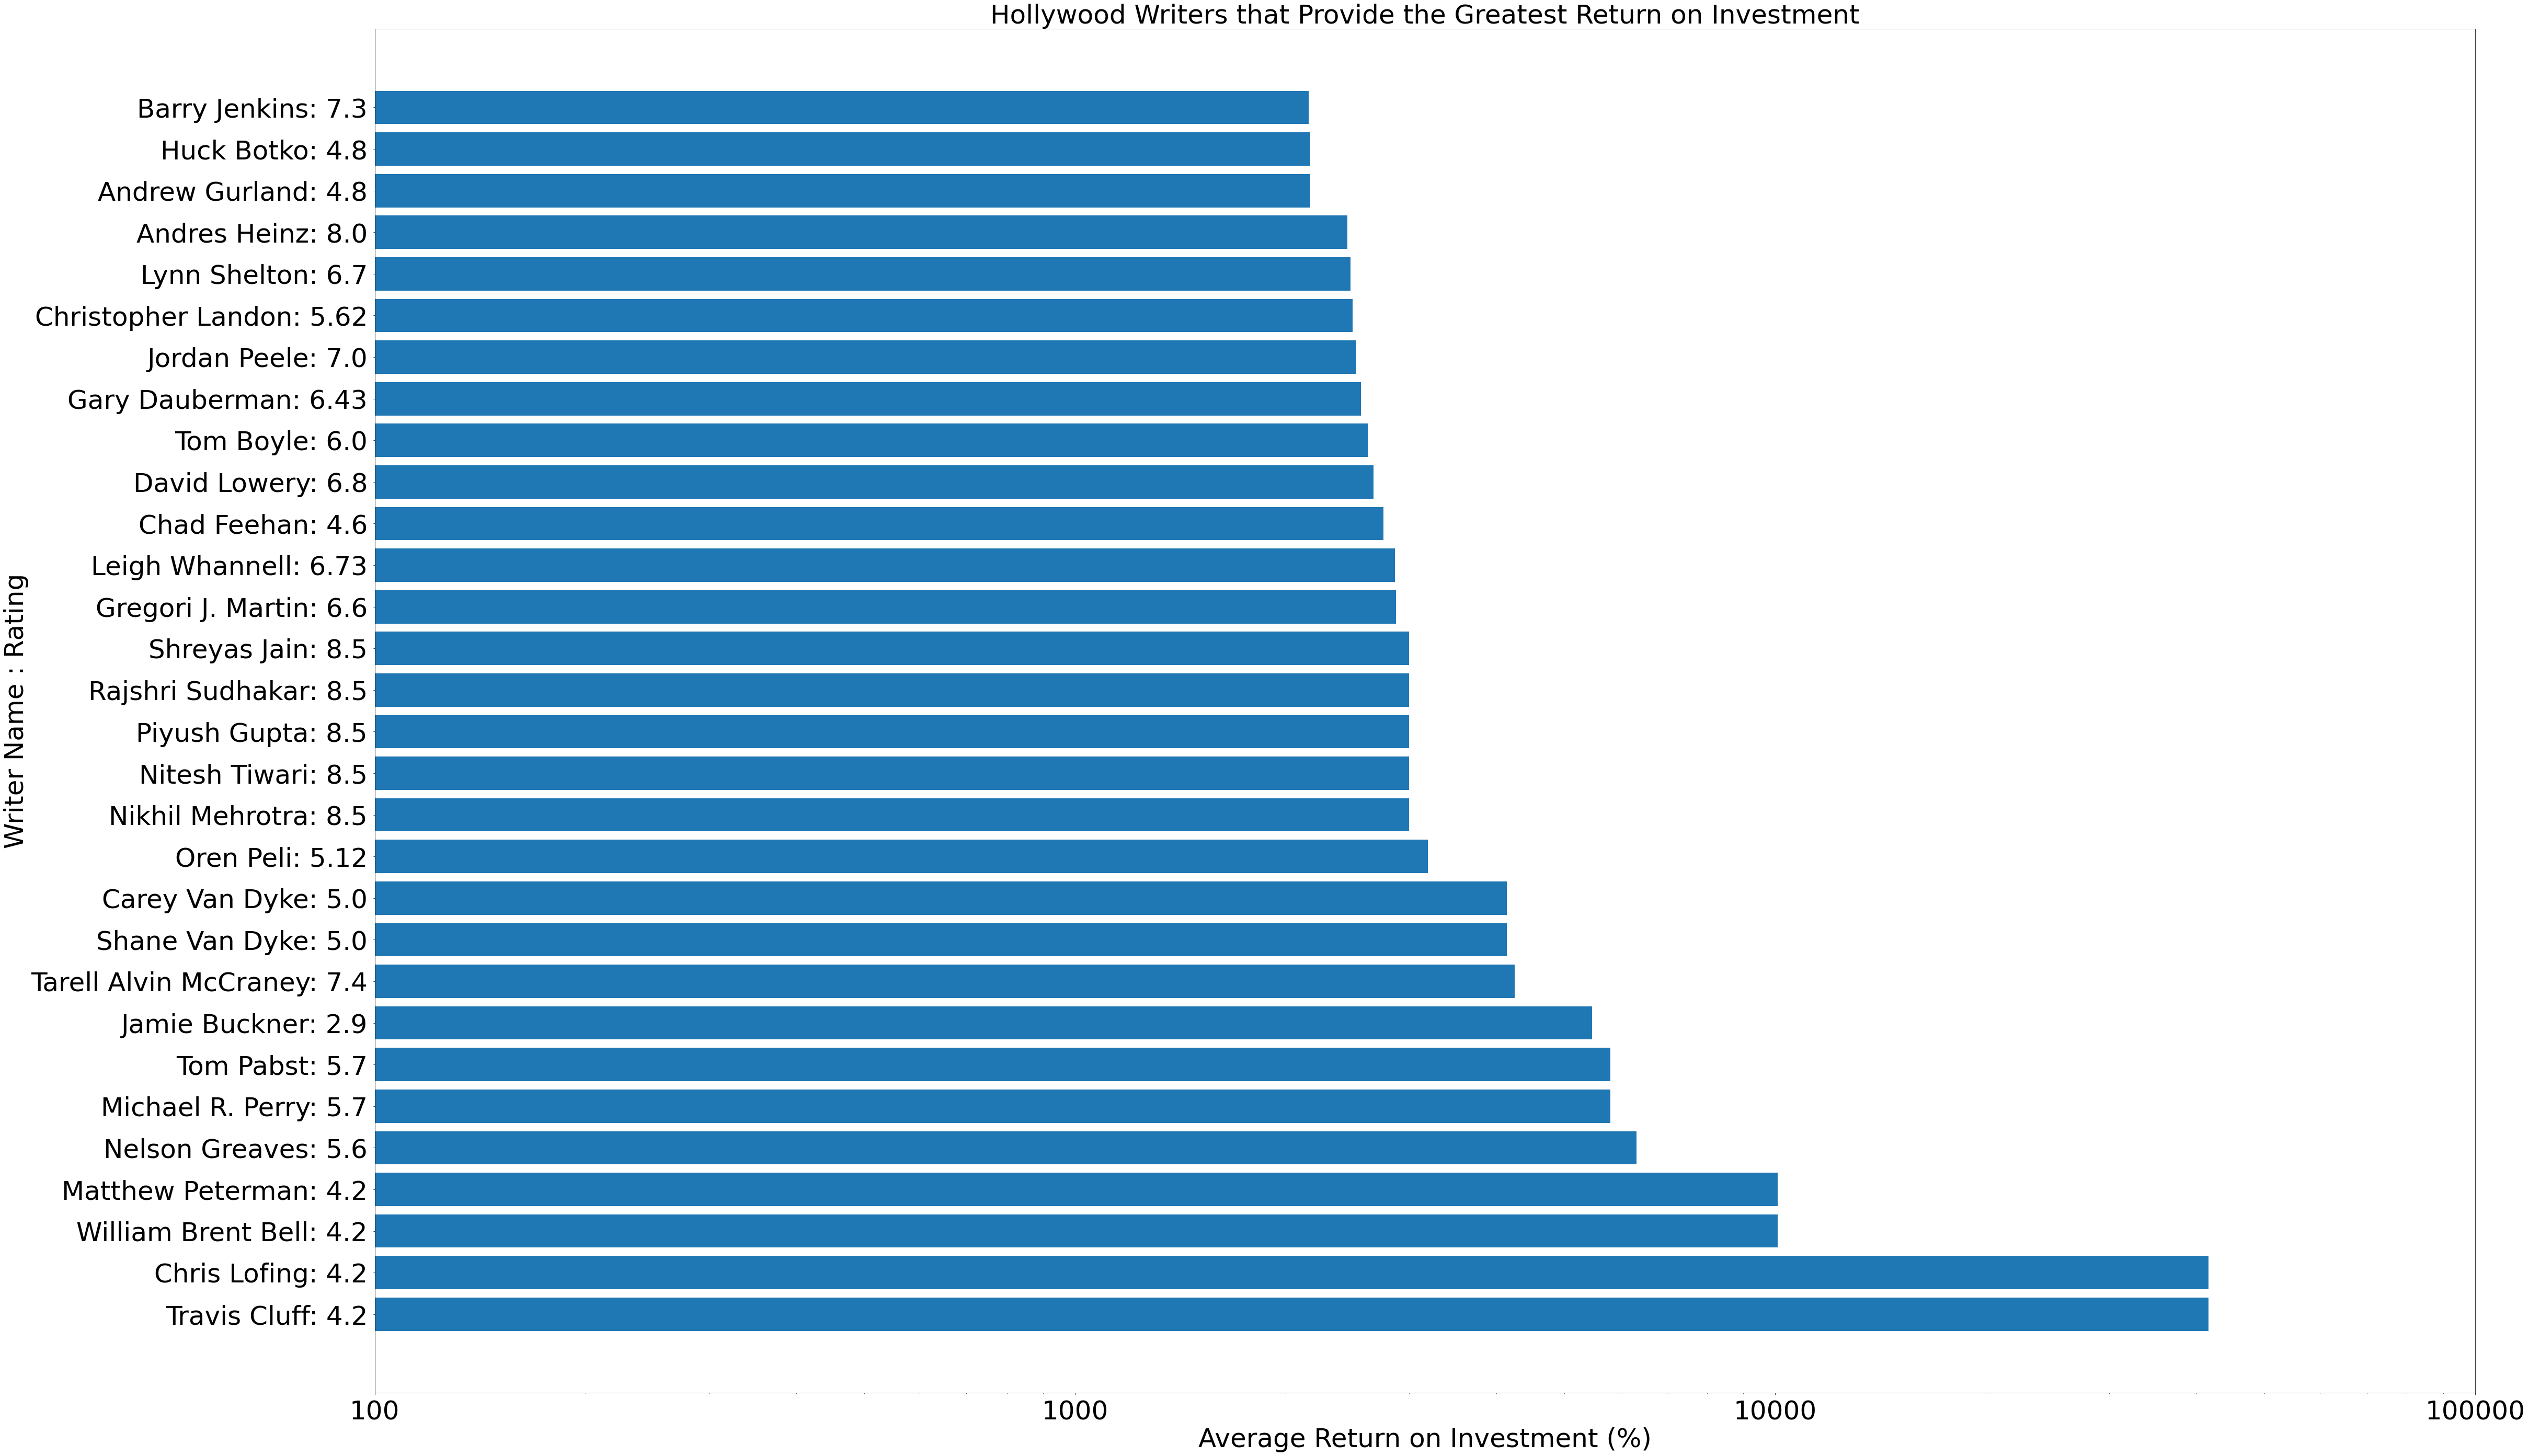

In [14]:
from matplotlib.ticker import ScalarFormatter
fig, ax = plt.subplots(figsize = (72,48))
x = names_with_rating
y = writers_plot['ROI']
ax.barh(x,y)
ax.set_xscale('log')
ax.set_xticks([100, 1000, 10000, 100000])
ax.set_xlabel('Average Return on Investment (%)', size = 50)
ax.set_title('Hollywood Writers that Provide the Greatest Return on Investment', size = 50)
ax.set_ylabel('Writer Name : Rating', size = 50)
ax.tick_params(axis='both', which='major', labelsize=50, pad = 10)
ax.tick_params(axis='y', which='minor', labelsize=50, pad = 15)
for axis in [ax.xaxis]:
    axis.set_major_formatter(ScalarFormatter());
plt.savefig('top30writersROI.png')

Finding the average rating by genre of each of the top writers.

In [15]:
genres = writers_profit.assign(genres = lambda x :writers_profit['genres'].str.split(',')).explode('genres')
writers_genre = genres.where(genres['ROI'] > 2491).groupby(['genres','primary_name']).mean('ROI').sort_values('averagerating', ascending = False)

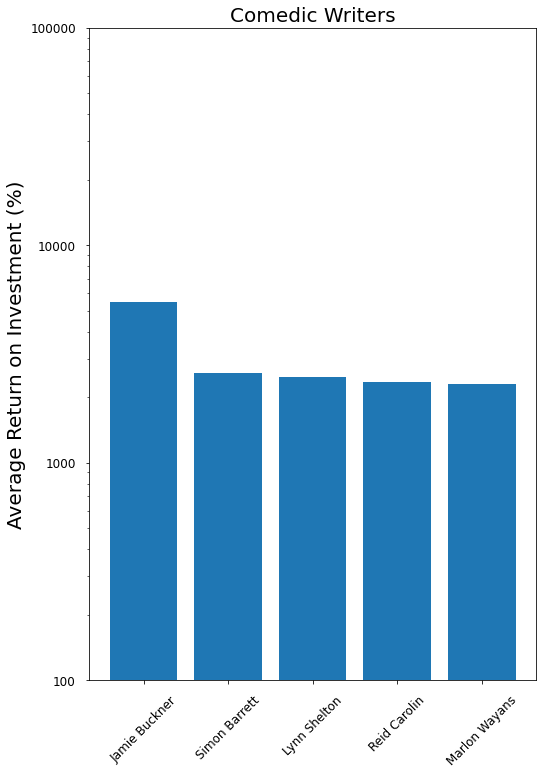

In [68]:
comedy_writers = genres.where((genres['ROI'] > 2000) & (genres['genres'] == 'Comedy')).groupby('primary_name').mean('ROI').sort_values('ROI', ascending = False)
comedy_writers = comedy_writers[['averagerating','numvotes','ROI']]
comedy_writers

fig, ax2 = plt.subplots(figsize = (8,12))
x = comedy_writers.index[:5]
y = comedy_writers['ROI'][:5]
ax2.bar(x,y)
ax2.set_yscale('log')
ax2.set_yticks([100, 1000, 10000, 100000])
ax2.set_ylabel('Average Return on Investment (%)', size = 20)
ax2.set_title('Comedic Writers', size = 20)
ax2.tick_params(axis='y', which='major', labelsize=12, pad = 10)
ax2.tick_params(axis='y', which='minor', labelsize=20, pad = 15)
ax2.tick_params(axis='x', which='major', labelsize=12, pad = 10, rotation = 45)
for axis in [ax2.yaxis]:
    axis.set_major_formatter(ScalarFormatter());

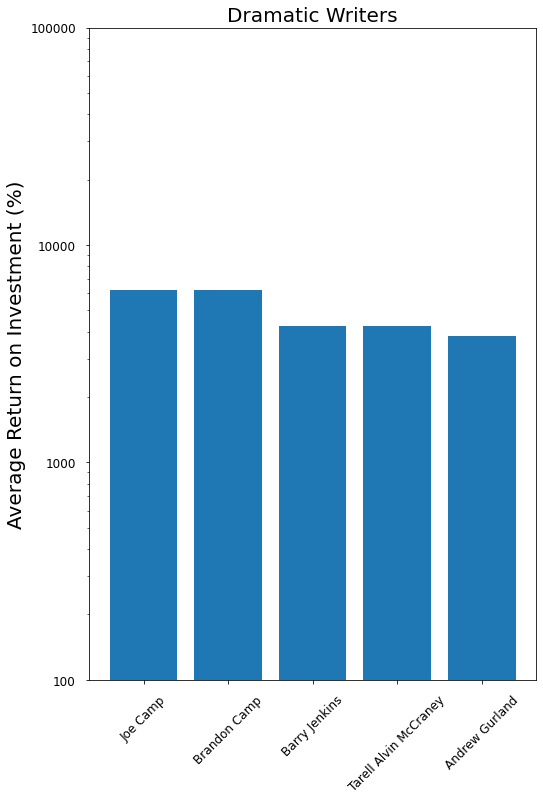

In [65]:
drama_writers = genres.where((genres['ROI'] > 2000) & (genres['genres'] == 'Drama')).groupby('primary_name').mean('ROI').sort_values('ROI', ascending = False)
drama_writers = drama_writers[['averagerating','numvotes','ROI']]

fig, ax2 = plt.subplots(figsize = (8,12))
x = drama_writers.index[:5]
y = drama_writers['ROI'][:5]
ax2.bar(x,y)
ax2.set_yscale('log')
ax2.set_yticks([100, 1000, 10000, 100000])
ax2.set_ylabel('Average Return on Investment (%)', size = 20)
ax2.set_title('Dramatic Writers', size = 20)
ax2.tick_params(axis='y', which='major', labelsize=12, pad = 10)
ax2.tick_params(axis='y', which='minor', labelsize=20, pad = 15)
ax2.tick_params(axis='x', which='major', labelsize=12, pad = 10, rotation = 45)
for axis in [ax2.yaxis]:
    axis.set_major_formatter(ScalarFormatter());

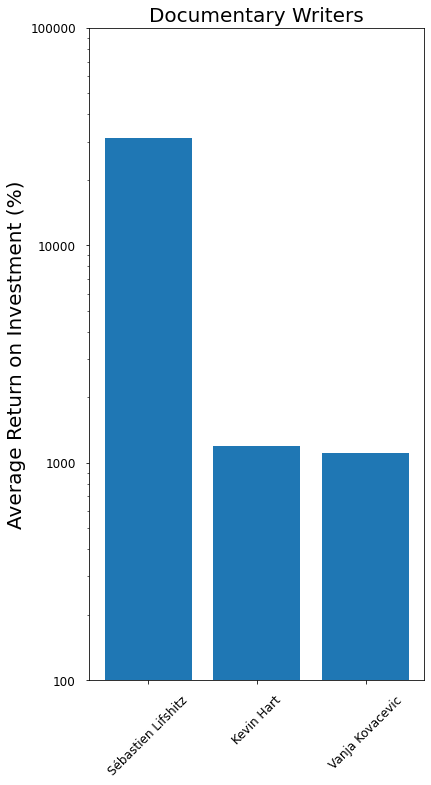

In [69]:
documentary_writers = genres.where((genres['ROI'] > 1000) & (genres['genres'] == 'Documentary')).groupby('primary_name').mean('ROI').sort_values('averagerating', ascending = False)
documentary_writers = documentary_writers[['averagerating','numvotes','ROI']]
documentary_writers

fig, ax2 = plt.subplots(figsize = (6,12))
x = documentary_writers.index[:5]
y = documentary_writers['ROI'][:5]
ax2.bar(x,y)
ax2.set_yscale('log')
ax2.set_yticks([100, 1000, 10000, 100000])
ax2.set_ylabel('Average Return on Investment (%)', size = 20)
ax2.set_title('Documentary Writers', size = 20)
ax2.tick_params(axis='y', which='major', labelsize=12, pad = 10)
ax2.tick_params(axis='y', which='minor', labelsize=20, pad = 15)
ax2.tick_params(axis='x', which='major', labelsize=12, pad = 10, rotation = 45)
for axis in [ax2.yaxis]:
    axis.set_major_formatter(ScalarFormatter());

In [19]:
directors = writers_profit[['tconst', 'directors', 'genres']]
directors = directors.assign(genres = lambda x :directors['genres'].str.split(','))
directors = directors.explode('genres')
directors = directors.merge(imdb_name['primary_name'], left_on = 'directors', right_on = imdb_name['nconst'], how = 'left')

In [20]:
best_directors = ['J.J. Abrams', 'Jared Bush', 'Gareth Edwards', 'Sam Mendes', 'Peter Jackson']
directors = directors.loc[directors['primary_name'].isin(best_directors)]
directors.groupby(['primary_name','genres']).count()

tconst  directors
primary_name   genres                      
Gareth Edwards Action         12         12
               Adventure      12         12
               Drama           1          1
               Sci-Fi         13         13
               Thriller        1          1
J.J. Abrams    Action          4          4
               Adventure       4          4
               Mystery         1          1
               Sci-Fi          5          5
               Thriller        1          1
Peter Jackson  Adventure      15         15
               Family          5          5
               Fantasy        15         15
Sam Mendes     Action          9          9
               Adventure       9          9
               Thriller        9          9